In [3]:
#packages
import pandas as pd
import numpy as np
#import pandas_profiling
import seaborn as sns
import math
import matplotlib.pyplot as plt
#from dateutil.parser import parse
import datetime
from scipy import stats
import pandas as pd

In [5]:
df_unique = pd.read_pickle('df_patient.pkl')


In [8]:
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import statsmodels.api as sm
import numpy as np
import pandas as pd

numeric_cols = df_unique.select_dtypes(include=['float64', 'int64']).columns
v0_cols_sfs = [col for col in numeric_cols if col.startswith('V0') and col not in ['V0_Colonisation_Bact_Si_Burkholderia_Preciser_le_Type_de_Genomovar', 'V0_Antecedant_Creatinine_Plasmatique_Pregreffe', 'V0_EFR_TM6_Sat_min']]

for centre in df_unique['V2VX_Centre_Suivi'].unique():
    data_sfs = df_unique.copy() 
    print(f"Processing centre: {centre}")
    
    # Creation d'une colonne binaire pour le centre en cours
    data_sfs[f'is_{centre}'] = (data_sfs['V2VX_Centre_Suivi'] == centre).astype(int)
    
    df_cleaned = data_sfs.dropna(subset=v0_cols_sfs + [f'is_{centre}'])
    X = df_cleaned[v0_cols_sfs]
    y = df_cleaned[f'is_{centre}']
    
    # sepration des données en train et test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Vérification si les données de test contiennent plus d'une classe
    if len(set(y_train)) < 2:
        print(f"Skipping centre {centre} because it has only one class in y_train.")
        continue
    
    # Normalisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    logistic_model = LogisticRegression(max_iter=10000, solver='lbfgs')
    
    # Sequential Feature Selector with StratifiedKFold
    skf = StratifiedKFold(n_splits=3)  # Adjust n_splits as needed

    # Silencing the FutureWarning
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        sfs = SFS(logistic_model, 
                  k_features='best', 
                  forward=True, 
                  floating=False, 
                  scoring='accuracy',
                  cv=skf)  
        
        # modele selection de features
        sfs = sfs.fit(X_train_scaled, y_train)
    
    # Get the indices of the selected features
    selected_features_indices = list(sfs.k_feature_idx_)
    
    # logistique model
    logistic_model.fit(X_train_scaled[:, selected_features_indices], y_train)
    
    # precision
    y_pred = logistic_model.predict(X_test_scaled[:, selected_features_indices])
    print(f"Accuracy {centre}: {accuracy_score(y_test, y_pred)}")
    
    # modele logistique
    X_train_selected = sm.add_constant(X_train_scaled[:, selected_features_indices])  
    sm_logistic_model = sm.Logit(y_train, X_train_selected).fit()
    
    # p_valeur, odds ratio, pseudo-R²
    p_values = sm_logistic_model.pvalues
    odds_ratios = np.exp(sm_logistic_model.params)
    llf = sm_logistic_model.llf  # Log-likelihood of the fitted model
    llnull = sm_logistic_model.llnull  # Log-likelihood of the null model
    
    # Calculate McFadden's pseudo-R²
    pseudo_r2_mcfadden = 1 - (llf / llnull)
    
    # Calculate adjusted pseudo-R²
    n = len(y_train)
    p = X_train_selected.shape[1] - 1
    r2_adj = 1 - (1 - pseudo_r2_mcfadden) * (n - 1) / (n - p - 1)
    
    # Create a DataFrame to display results
    results_df = pd.DataFrame({
        'Feature': ['Intercept'] + [v0_cols_sfs[i] for i in selected_features_indices],
        'Coefficient': sm_logistic_model.params,
        'Odds Ratio': odds_ratios,
        'P-Value': p_values
    })
    significant_results_df = results_df[results_df['P-Value'] < 0.05]
    
    print(f"Adjusted R²: {round(r2_adj, 2)}")
    print(f"Results for centre {centre}:\n", significant_results_df.head(10))
    print("\n\n")


Processing centre: Colt Marseille
Accuracy Colt Marseille: 0.8620689655172413
Optimization terminated successfully.
         Current function value: 0.349210
         Iterations 8
Adjusted R²: 0.28
Results for centre Colt Marseille:
                    Feature  Coefficient  Odds Ratio       P-Value
const            Intercept    -2.204589    0.110296  2.209367e-12
x5           V0_EFR_DLCO_%    -1.471288    0.229630  3.632929e-06
x11    V0_EFR_TM6_Distance     1.616738    5.036636  2.680097e-07
x15       V0_EFR_Tiffeneau     2.940789   18.930776  9.636142e-04



Processing centre: Colt Suresnes
Accuracy Colt Suresnes: 1.0
Optimization terminated successfully.
         Current function value: 0.084768
         Iterations 9
Adjusted R²: 0.03
Results for centre Colt Suresnes:
          Feature  Coefficient  Odds Ratio       P-Value
const  Intercept     -4.24302    0.014364  1.807609e-11



Processing centre: Colt Paris-HEGP
Skipping centre Colt Paris-HEGP because it has only one class in y_

In [62]:
# Préparation des données
# data1 = df_unique.copy()

# # Sélectionner les colonnes numériques
# numerical_cols = data1.select_dtypes(include=['float64', 'int64']).columns

# # Filtrer les colonnes qui commencent par V0
# v0_cols = [col for col in numerical_cols if col.startswith('V0') and col not in [
#     'V0_Colonisation_Bact_Si_Burkholderia_Preciser_le_Type_de_Genomovar', 
#     'V0_Antecedant_Creatinine_Plasmatique_Pregreffe', 'V0_EFR_TM6_Sat_min']]

# # Remplacer les valeurs manquantes par la médiane du centre
# for col in v0_cols:
#     data1[col] = data1.groupby('V2VX_Centre_Suivi', observed=False)[col].transform(lambda x: x.fillna(x.median()))

# data_var_v0 = pd.concat([data1['V2VX_Centre_Suivi'], data1[v0_cols]], axis=1)

# # Sélectionner les colonnes numériques
data_var_v0 = df_unique.copy()
numerical_cols = data_var_v0.select_dtypes(include=['float64', 'int64']).columns

# Filtrer les colonnes qui commencent par V0
v0_cols = [col for col in numerical_cols if col.startswith('V0') and col not in [
    'V0_Colonisation_Bact_Si_Burkholderia_Preciser_le_Type_de_Genomovar', 
    'V0_Antecedant_Creatinine_Plasmatique_Pregreffe']]

# for col in v0_cols:
#     data_var_v0[col] = data_var_v0.groupby('V2VX_Centre_Suivi', observed=False)[col].transform(lambda x: x.fillna(x.median()))
data_var_v0 = pd.concat([data_var_v0['V2VX_Centre_Suivi'], data_var_v0[v0_cols]], axis=1)

In [63]:
data_var_v0

,V2VX_Centre_Suivi,V0_EFR_VEMS,V0_EFR_VEMS%,V0_EFR_CVF,V0_EFR_CVF%,V0_EFR_DLCO_%,V0_EFR_CPT,V0_EFR_CPT%,V0_EFR_VR,V0_EFR_VR%,...,V0_GDS_HCO3,V0_GDS_PaCO2_(kPa),V0_GDS_PaCO2_(mmHg),V0_GDS_PaO2_(kPa),V0_GDS_PaO2_(mmHg),V0_Generales_Age,V0_Generales_Taille,V0_Generales_Poids,V0_EFR_Tiffeneau,V0_Generales_BMI
0,Colt Marseille,0.56,16.9,0.97,25.7,NaN,5.26,103.1,3.77,271.9,...,31.6,6.60,49.7,6.80,51.0,24.0,165.0,49.0,0.577320,17.998163
1,Colt Marseille,1.26,51.0,1.66,57.4,NaN,3.77,78.0,2.12,121.4,...,26.0,5.80,44.0,6.00,45.0,52.0,161.0,52.0,0.759036,20.060954
2,Colt Marseille,0.67,23.5,1.20,36.4,NaN,4.55,104.1,3.26,274.9,...,33.0,7.20,54.0,8.60,65.0,21.0,154.0,40.0,0.558333,16.866251
3,Colt Marseille,0.51,26.7,1.07,46.8,NaN,5.27,126.2,3.87,233.0,...,28.0,5.80,43.5,8.60,65.0,62.0,151.0,52.0,0.476636,22.806017
4,Colt Marseille,0.63,23.4,1.12,35.9,NaN,3.49,85.0,2.27,203.3,...,NaN,5.07,38.0,7.73,58.0,24.0,150.0,34.0,0.562500,15.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1802,Colt Suresnes,1.31,35.0,2.96,63.0,NaN,NaN,174.0,9.12,401.0,...,NaN,4.20,32.0,11.30,85.0,53.0,180.0,93.0,0.442568,28.703704
1803,Colt Suresnes,1.21,35.0,3.60,79.0,NaN,6.66,91.0,5.57,221.0,...,18.2,3.70,28.0,9.70,73.0,63.0,179.0,80.0,0.336111,24.968010
1804,Colt Marseille,1.41,40.0,1.69,37.0,NaN,3.30,45.0,1.59,63.0,...,27.2,5.60,42.0,16.10,121.0,63.0,180.0,70.0,0.834320,21.604938
1805,Colt Marseille,1.51,43.0,1.88,43.0,18.0,3.55,55.0,1.58,74.0,...,29.9,5.80,44.0,14.40,108.0,53.0,170.0,71.0,0.803191,24.567474


Analyzing Colt Marseille vs All


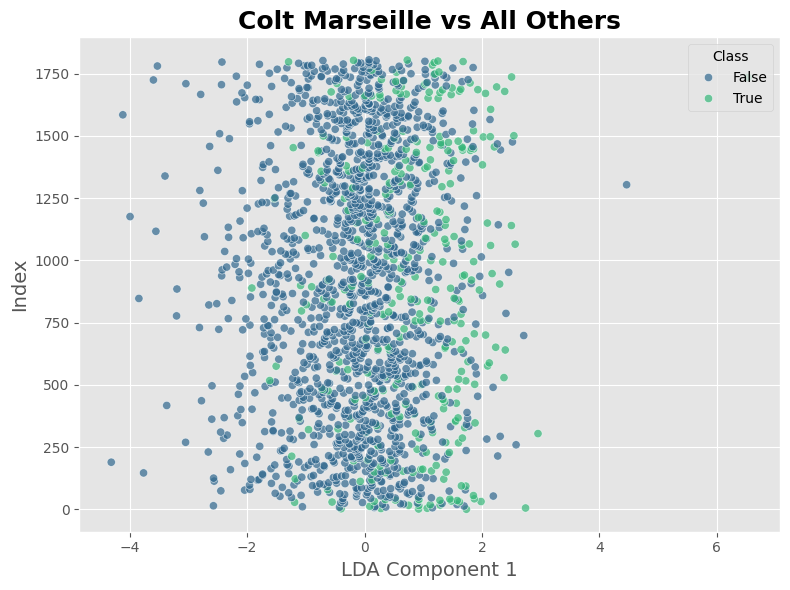

Analyzing Colt Suresnes vs All


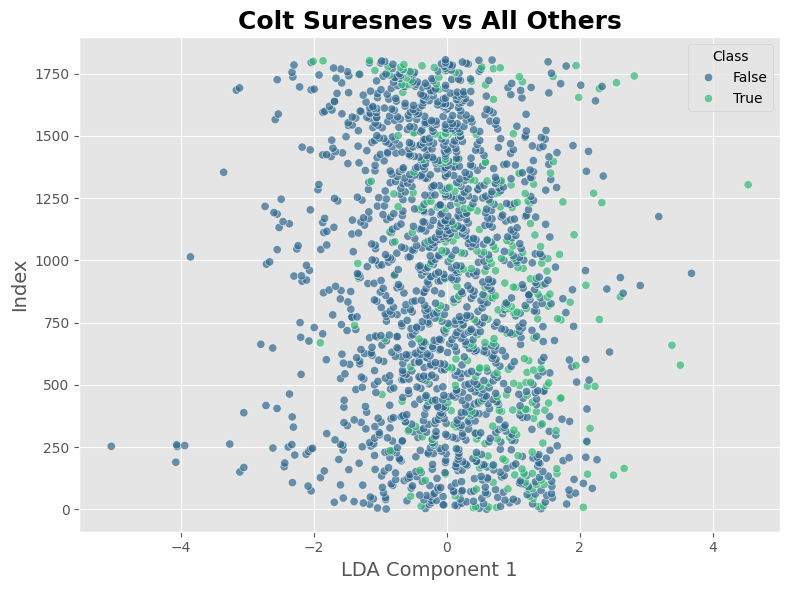

Analyzing Colt Paris-HEGP vs All


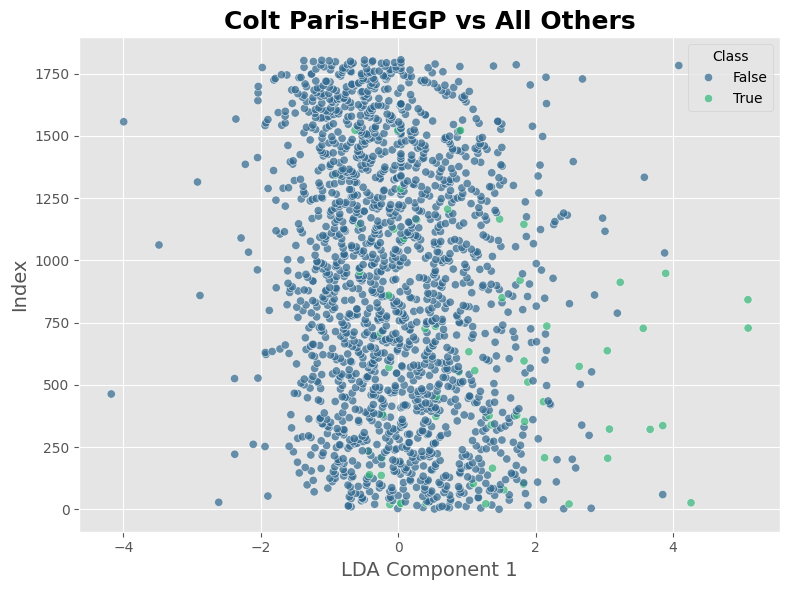

Analyzing Colt Nantes vs All


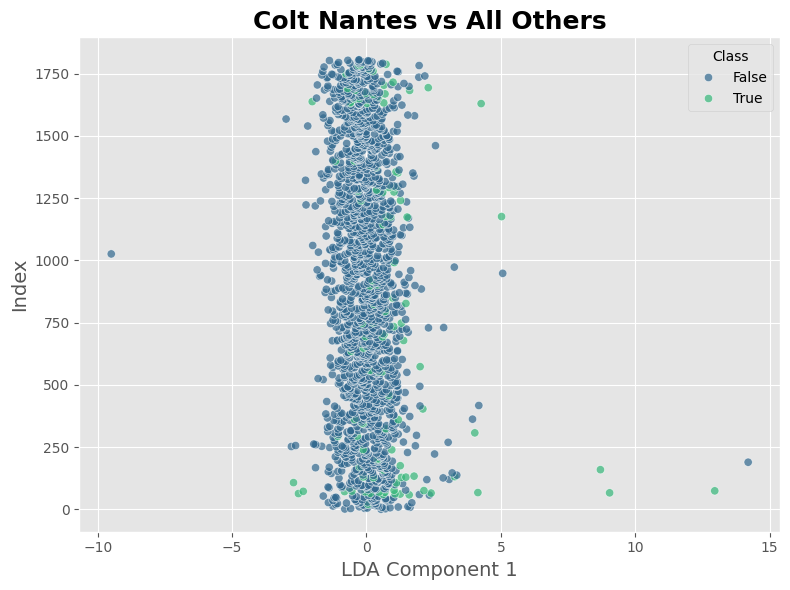

Analyzing Colt Bordeaux vs All


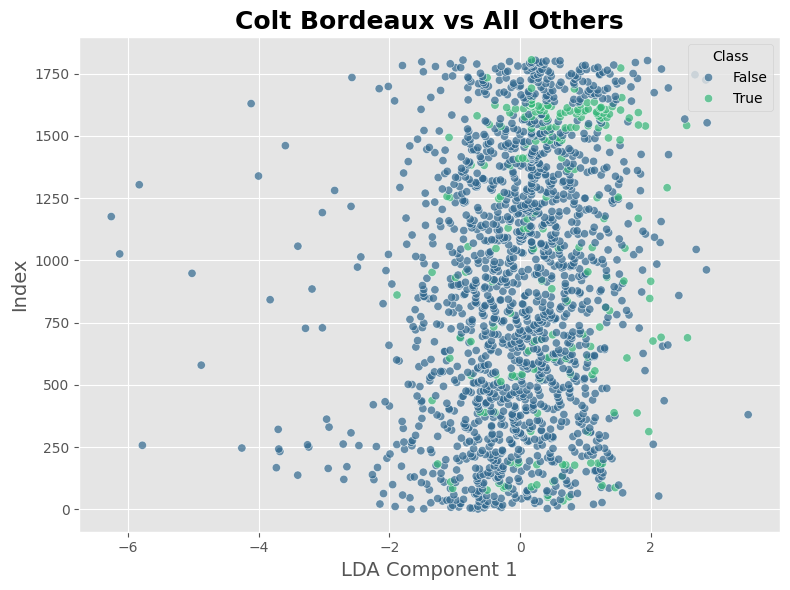

Analyzing Colt Le-Plessis-Robinson vs All


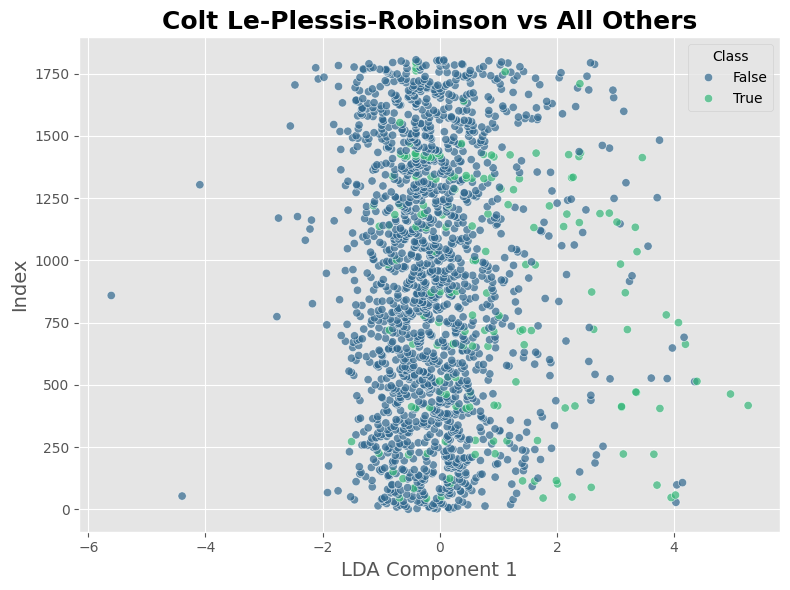

Analyzing Colt Grenoble vs All


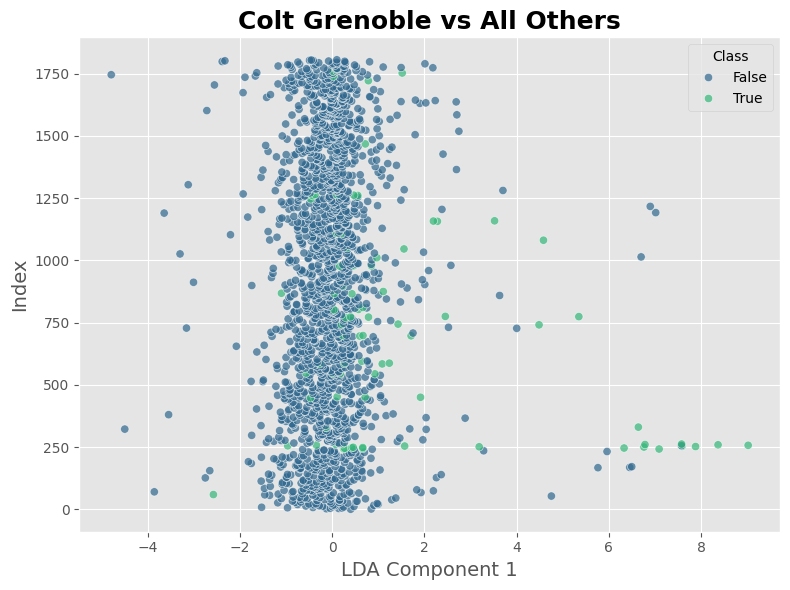

Analyzing Colt Strasbourg vs All


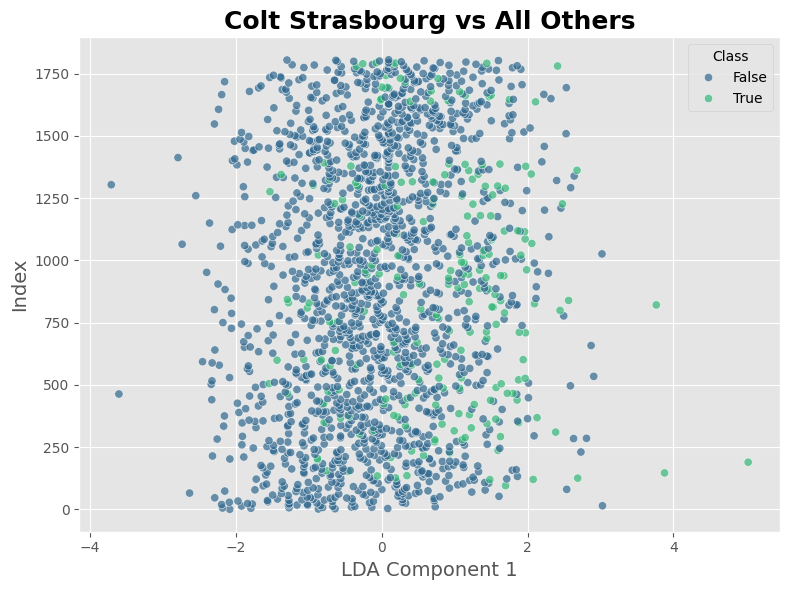

Analyzing Colt Lyon vs All


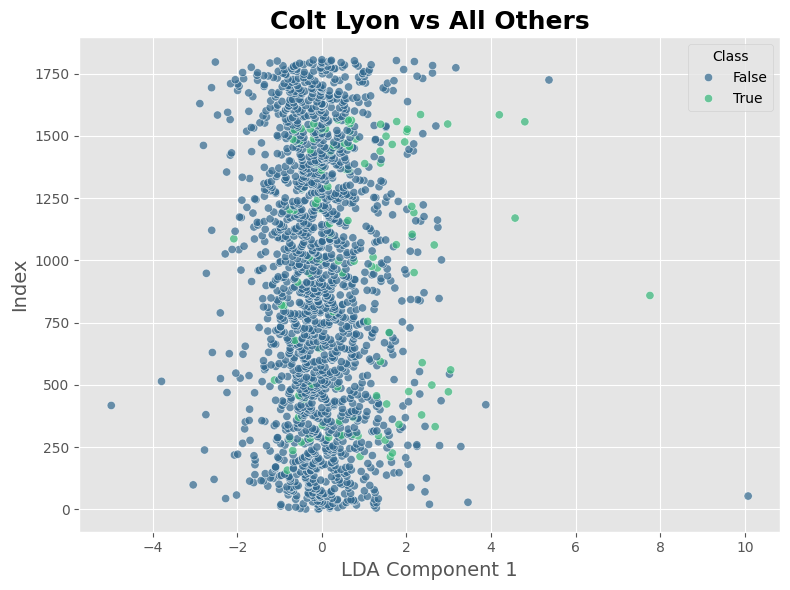

Analyzing Colt Paris-Bichat vs All


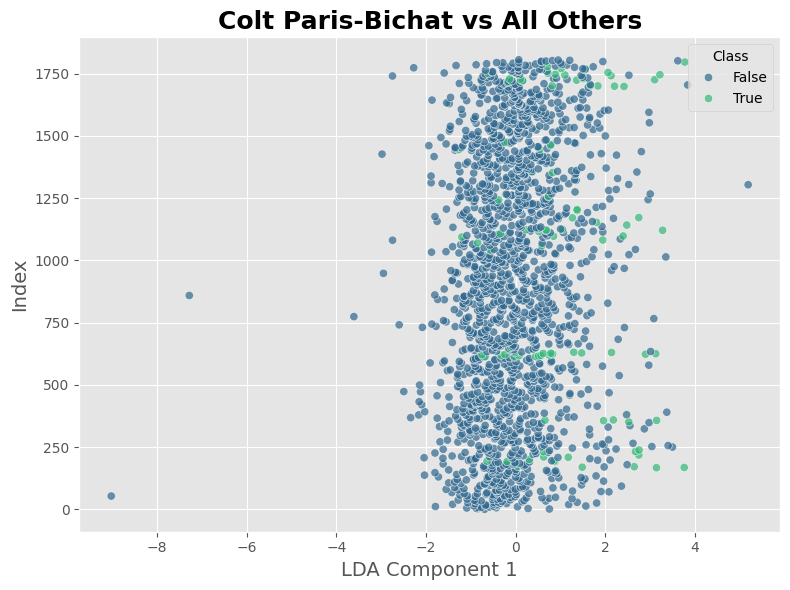

Analyzing Colt Toulouse vs All


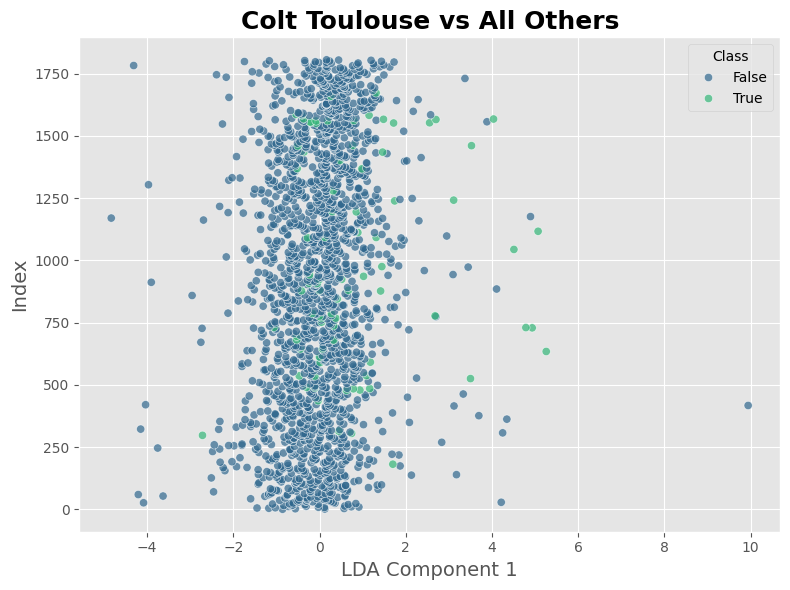

Analyzing Colt Bruxelles vs All


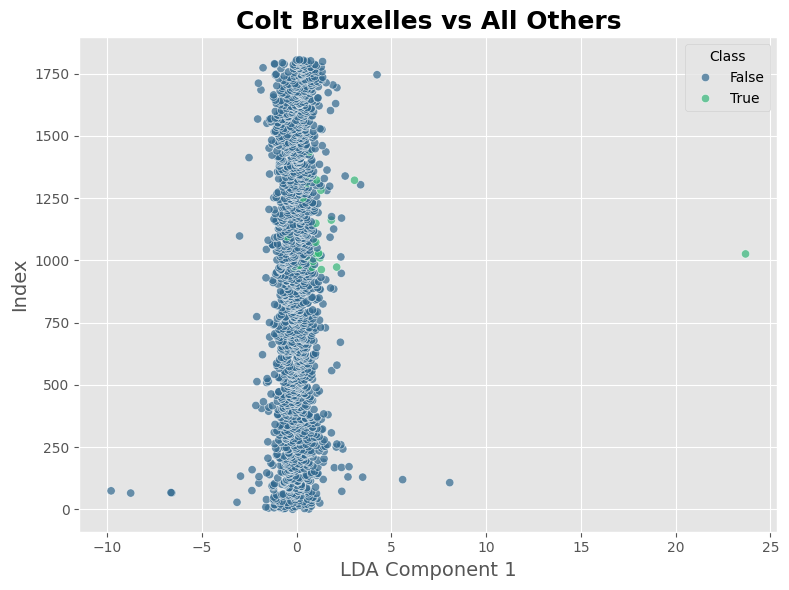

In [64]:
# Corrected code snippet to address the NameError for 'lda_coefs'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Assuming 'df_unique' and 'v0_cols' are defined elsewhere in the notebook

def lda_by_centre_analysis(data, v0_cols):
    plt.style.use('ggplot')
   
    centres = data['V2VX_Centre_Suivi'].unique()
    lda_coefs = {}

    for centre in centres:
        print(f"Analyzing {centre} vs All")
        
        # Select the numerical variables
        X = data[v0_cols]
        y = (data['V2VX_Centre_Suivi'] == centre)

        # Impute missing values
        imputer = SimpleImputer(strategy='median')
        X_imputed = imputer.fit_transform(X)

        # Standardize the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_imputed)
        
        n_features = X_scaled.shape[1]
        n_classes = len(np.unique(y))
        n_components = min(n_features, n_classes - 1)

        # Check if n_components is at least 1
        if n_components < 1:
            raise ValueError("LDA cannot be performed with the given data. Ensure there are at least two classes and sufficient features.")
        
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        lda.fit(X_scaled, y)
        X_lda = lda.transform(X_scaled)

        # Store LDA coefficients for the heatmap
        lda_coefs[centre] = lda.coef_[0]
        
        # Create a DataFrame for the LDA result
        temp_df = pd.DataFrame(X_lda, columns=[f'LDA Component {i+1}' for i in range(n_components)])
        temp_df['Class'] = y
        
        # Plot the LDA results
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=temp_df, x=temp_df.columns[0], y=temp_df.columns[1] if n_components > 1 else temp_df.index, hue='Class', palette='viridis', alpha=0.7)
        plt.title(f'{centre} vs All Others', fontsize=18, weight='bold')
        plt.xlabel(temp_df.columns[0], fontsize=14)
        plt.ylabel(temp_df.columns[1] if n_components > 1 else 'Index', fontsize=14)
        plt.grid(True)
        plt.legend(title='Class', loc='upper right')
        plt.tight_layout()
        plt.show()

    # # Plot a heatmap of contribution scores
    # lda_coef_df = pd.DataFrame.from_dict(lda_coefs, orient='index', columns=v0_cols)
    # lda_coef_df = lda_coef_df.transpose()
    # plt.figure(figsize=(14, 10))
    # sns.heatmap(lda_coef_df, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
    # plt.title('Contribution Scores of Variables', fontsize=18, weight='bold')
    # plt.xlabel('Features', fontsize=14)
    # plt.ylabel('Centres', fontsize=14)
    # plt.xticks(ha='right')
    # plt.yticks(rotation=0)
    # plt.tight_layout()
    # plt.show()

# Call the function with 'data_var_v0' and 'v0_cols' defined elsewhere
lda_by_centre_analysis(data_var_v0, v0_cols)